In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import tensorflow as tf
tf.keras.utils.set_random_seed(3)
from tqdm import tqdm
from tensorflow.keras.utils import plot_model
import time

# Data

In [2]:
# train_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/train.npz"
# test_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/data/test.npz"
# model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/vq_vae2.h5"
# pixelcnnt_model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/vq_vae2_Gpixelcnn_top.h5"
# pixelcnnb_model_path = "/content/drive/MyDrive/Cursos/TFM_AI/TFM/aplicacion/models/vq_vae2_Gpixelcnn_bottom.h5"

train_path = "data/train.npz"
test_path = "data/test.npz"
model_path = "models/vq_vae2.h5"
pixelcnnt_model_path = "models/vq_vae2_Gpixelcnn_top.h5"
pixelcnnb_model_path = "models/vq_vae2_Gpixelcnn_bottom_i.h5"

In [3]:
train_data = np.load(train_path)
X_train = train_data["arr_0"]
y_train = train_data["arr_1"]
X_train.shape, y_train.shape

((10000, 128, 128, 1), (10000,))

In [4]:
test_data = np.load(test_path)
X_test = test_data["arr_0"]
y_test = test_data["arr_1"]
X_test.shape, y_test.shape

((400, 128, 128, 1), (400,))

In [5]:
X_train = X_train / 255.
X_test = X_test / 255.

# Model

In [6]:
latent_dim = 8
num_embeddings=16

In [8]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened) #aquí calcula el punto más cercano del embedding al x
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        codebook_indices = tf.reshape(encoding_indices, input_shape[:-1])

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized, codebook_indices

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices
    
    def quantize_from_priors(self, priors): #is will be used for generation with pixelcnn
        priors_ohe = tf.one_hot(priors.astype("int32"), self.num_embeddings).numpy()
        quantized = tf.matmul(priors_ohe.astype("float32"), self.embeddings, transpose_b=True)
        return np.squeeze(quantized)
    
    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'num_embeddings': self.num_embeddings,
            'embedding_dim': self.embedding_dim,
            'beta': self.beta
        })
        return config

In [8]:
def get_encoder_b(latent_dim=16, input_shape=(128,128,1)):
    encoder_inputs = keras.Input(shape=input_shape)
    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder_b")
get_encoder_b(latent_dim).summary()

Model: "encoder_b"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                         

In [9]:
def get_encoder_t(latent_dim=16, input_shape=(32,32,8)):
    encoder_inputs = keras.Input(shape=input_shape)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder_inputs)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    encoder_outputs = layers.Conv2D(latent_dim, 1, padding="same")(x)
    
    return keras.Model(encoder_inputs, encoder_outputs, name="encoder_t")
get_encoder_t(latent_dim, get_encoder_b(latent_dim).output.shape[1:]).summary()

Model: "encoder_t"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 8)]  0           []                               
                                                                                                  
 conv2d_14 (Conv2D)             (None, 32, 32, 64)   4672        ['input_3[0][0]']                
                                                                                                  
 conv2d_15 (Conv2D)             (None, 32, 32, 64)   36928       ['conv2d_14[0][0]']              
                                                                                                  
 tf.math.add_6 (TFOpLambda)     (None, 32, 32, 64)   0           ['conv2d_15[0][0]',              
                                                                  'conv2d_14[0][0]']      

In [10]:
def get_decoder_t(latent_dim=16, input_shape=(16,16,8)):
    latent_inputs = keras.Input(shape=input_shape)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(latent_inputs)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoder_outputs = layers.Conv2D(latent_dim, 3, padding="same")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder_t")
get_decoder_t(latent_dim, get_encoder_t(latent_dim).output.shape[1:]).summary()

Model: "decoder_t"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 16, 16, 8)]  0           []                               
                                                                                                  
 conv2d_28 (Conv2D)             (None, 16, 16, 128)  9344        ['input_5[0][0]']                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 16, 16, 128)  147584      ['conv2d_28[0][0]']              
                                                                                                  
 tf.math.add_12 (TFOpLambda)    (None, 16, 16, 128)  0           ['conv2d_29[0][0]',              
                                                                  'conv2d_28[0][0]']      

In [11]:
def get_decoder_b(input_shape=(32,32,8)):
    latent_inputs = keras.Input(shape=input_shape)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(latent_inputs)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
#    x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)

    x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    x = tf.add(x, x1)
    x = layers.BatchNormalization()(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    decoder_outputs = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)
    return keras.Model(latent_inputs, decoder_outputs, name="decoder_b")
get_decoder_b(get_encoder_b(latent_dim).output.shape[1:-1]+(3*latent_dim,)).summary()

Model: "decoder_b"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 24)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_42 (Conv2D)             (None, 32, 32, 128)  27776       ['input_7[0][0]']                
                                                                                                  
 conv2d_43 (Conv2D)             (None, 32, 32, 128)  147584      ['conv2d_42[0][0]']              
                                                                                                  
 tf.math.add_18 (TFOpLambda)    (None, 32, 32, 128)  0           ['conv2d_43[0][0]',      

In [12]:
def get_vqvae(latent_dim=16, num_embeddings=64, input_shape=(128,128,1)):
    vq_layer_b = VectorQuantizer(num_embeddings, latent_dim*2, name="vector_quantizer_b") 
    #latent_dim*2 because it will apply to the concatenation of enc_b, dec_t which will have doble channels
    vq_layer_t = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer_t")

    encoder_b = get_encoder_b(latent_dim, input_shape)
    encoder_t = get_encoder_t(latent_dim, encoder_b.output.shape[1:])
    decoder_t = get_decoder_t(latent_dim, encoder_t.output.shape[1:])
    decoder_b = get_decoder_b(encoder_b.output.shape[1:-1]+(3*latent_dim,))

    inputs = keras.Input(shape=input_shape)

    enc_b = encoder_b(inputs)

    enc_t = encoder_t(enc_b)
    quant_t, prior_t = vq_layer_t(enc_t)
    dec_t = decoder_t(quant_t)
    enc_b = layers.Concatenate()([enc_b, dec_t])

    quant_b, prior_b = vq_layer_b(enc_b)
    quant_t = layers.UpSampling2D((2,2))(quant_t)
    quant_b = layers.Concatenate()([quant_b, quant_t])

    reconstructions = decoder_b(quant_b)

    return keras.Model(inputs, [reconstructions, prior_t, prior_b], name="vq_vae")
get_vqvae(latent_dim, num_embeddings).summary()

Model: "vq_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_b (Functional)         (None, 32, 32, 8)    556488      ['input_12[0][0]']               
                                                                                                  
 encoder_t (Functional)         (None, 16, 16, 8)    560520      ['encoder_b[0][0]']              
                                                                                                  
 vector_quantizer_t (VectorQuan  ((None, 16, 16, 8),  128        ['encoder_t[0][0]']         

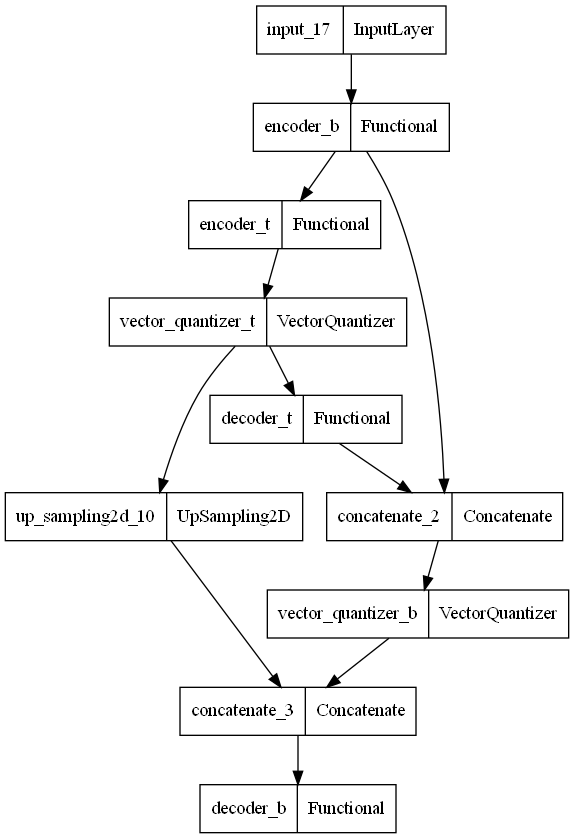

In [13]:
plot_model(get_vqvae(latent_dim, num_embeddings))

In [14]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, img_shape=(128,128,1), **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, img_shape)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions, _, _ = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result(),
        }
    
    def test_step(self, x):
        reconstructions, _, _ = self.vqvae(x)
        # Calculate the losses.
        reconstruction_loss = (
            tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
        )
        total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "r_loss": self.reconstruction_loss_tracker.result(),
            "vq_loss": self.vq_loss_tracker.result(),
        }

In [15]:
data_variance = np.var(X_train)

In [16]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim=latent_dim, num_embeddings=num_embeddings)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam(0.001))

In [17]:
init_time = time.time()
logs = vqvae_trainer.fit(X_train, epochs=100, batch_size=32, 
               validation_data=(X_test, None), 
               callbacks=[early_stop, reduce_lr])
print(f"Total time: {time.time() - init_time} (s)")

Epoch 1/100
313/313 [==============================] - 48s 130ms/step - loss: 21.9934 - r_loss: 0.4498 - vq_loss: 10.1839 - val_loss: 0.6136 - val_r_loss: 0.0964 - val_vq_loss: 0.5172 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 39s 124ms/step - loss: 0.3987 - r_loss: 0.1038 - vq_loss: 0.2306 - val_loss: 0.1998 - val_r_loss: 0.0590 - val_vq_loss: 0.1408 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 39s 124ms/step - loss: 0.1669 - r_loss: 0.0689 - vq_loss: 0.0783 - val_loss: 2.1036 - val_r_loss: 1.6594 - val_vq_loss: 0.4441 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 39s 124ms/step - loss: 1.0886 - r_loss: 0.2849 - vq_loss: 0.2601 - val_loss: 0.0937 - val_r_loss: 0.0480 - val_vq_loss: 0.0457 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 39s 124ms/step - loss: 0.1037 - r_loss: 0.0622 - vq_loss: 0.0383 - val_loss: 0.0790 - val_r_loss: 0.0417 - val_vq_loss: 0.0373 - lr: 0.0010
Epoch 6/100
313/313 [==

In [18]:
vae = vqvae_trainer.vqvae

In [19]:
vae.save(model_path)

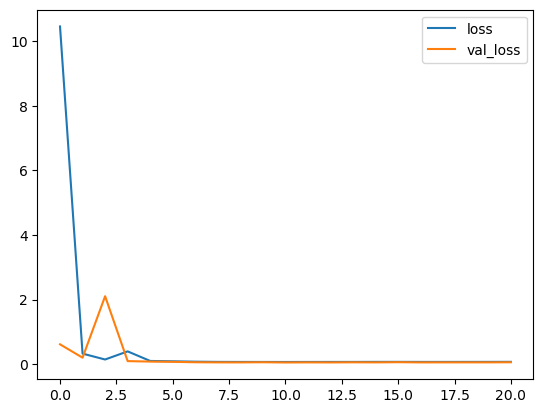

In [20]:
plt.plot(logs.history['loss'], label="loss")
plt.plot(logs.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

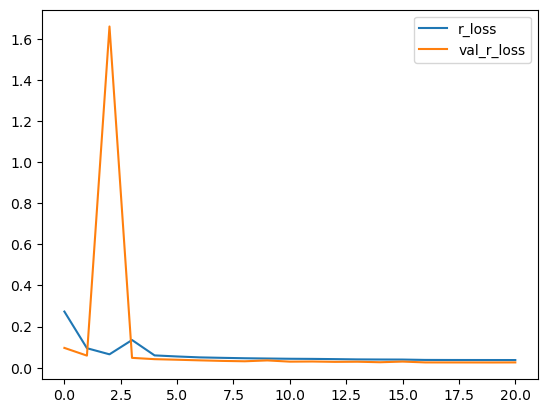

In [21]:
plt.plot(logs.history['r_loss'], label="r_loss")
plt.plot(logs.history['val_r_loss'], label="val_r_loss")
plt.legend()
plt.show()

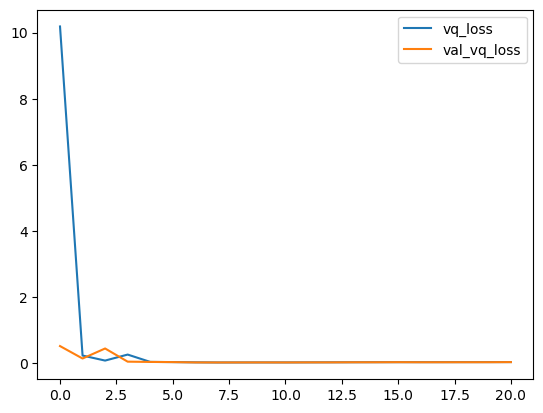

In [22]:
plt.plot(logs.history['vq_loss'], label="vq_loss")
plt.plot(logs.history['val_vq_loss'], label="val_vq_loss")
plt.legend()
plt.show()

# Testing

In [9]:
#Optional
vae = keras.models.load_model(model_path, custom_objects={'VectorQuantizer': VectorQuantizer}, compile=False)
vae.summary()

Model: "vq_vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_b (Functional)         (None, 32, 32, 8)    556488      ['input_22[0][0]']               
                                                                                                  
 encoder_t (Functional)         (None, 16, 16, 8)    560520      ['encoder_b[0][0]']              
                                                                                                  
 vector_quantizer_t (VectorQuan  ((None, 16, 16, 8),  128        ['encoder_t[0][0]']         

13/13 [==============================] - 1s 54ms/step


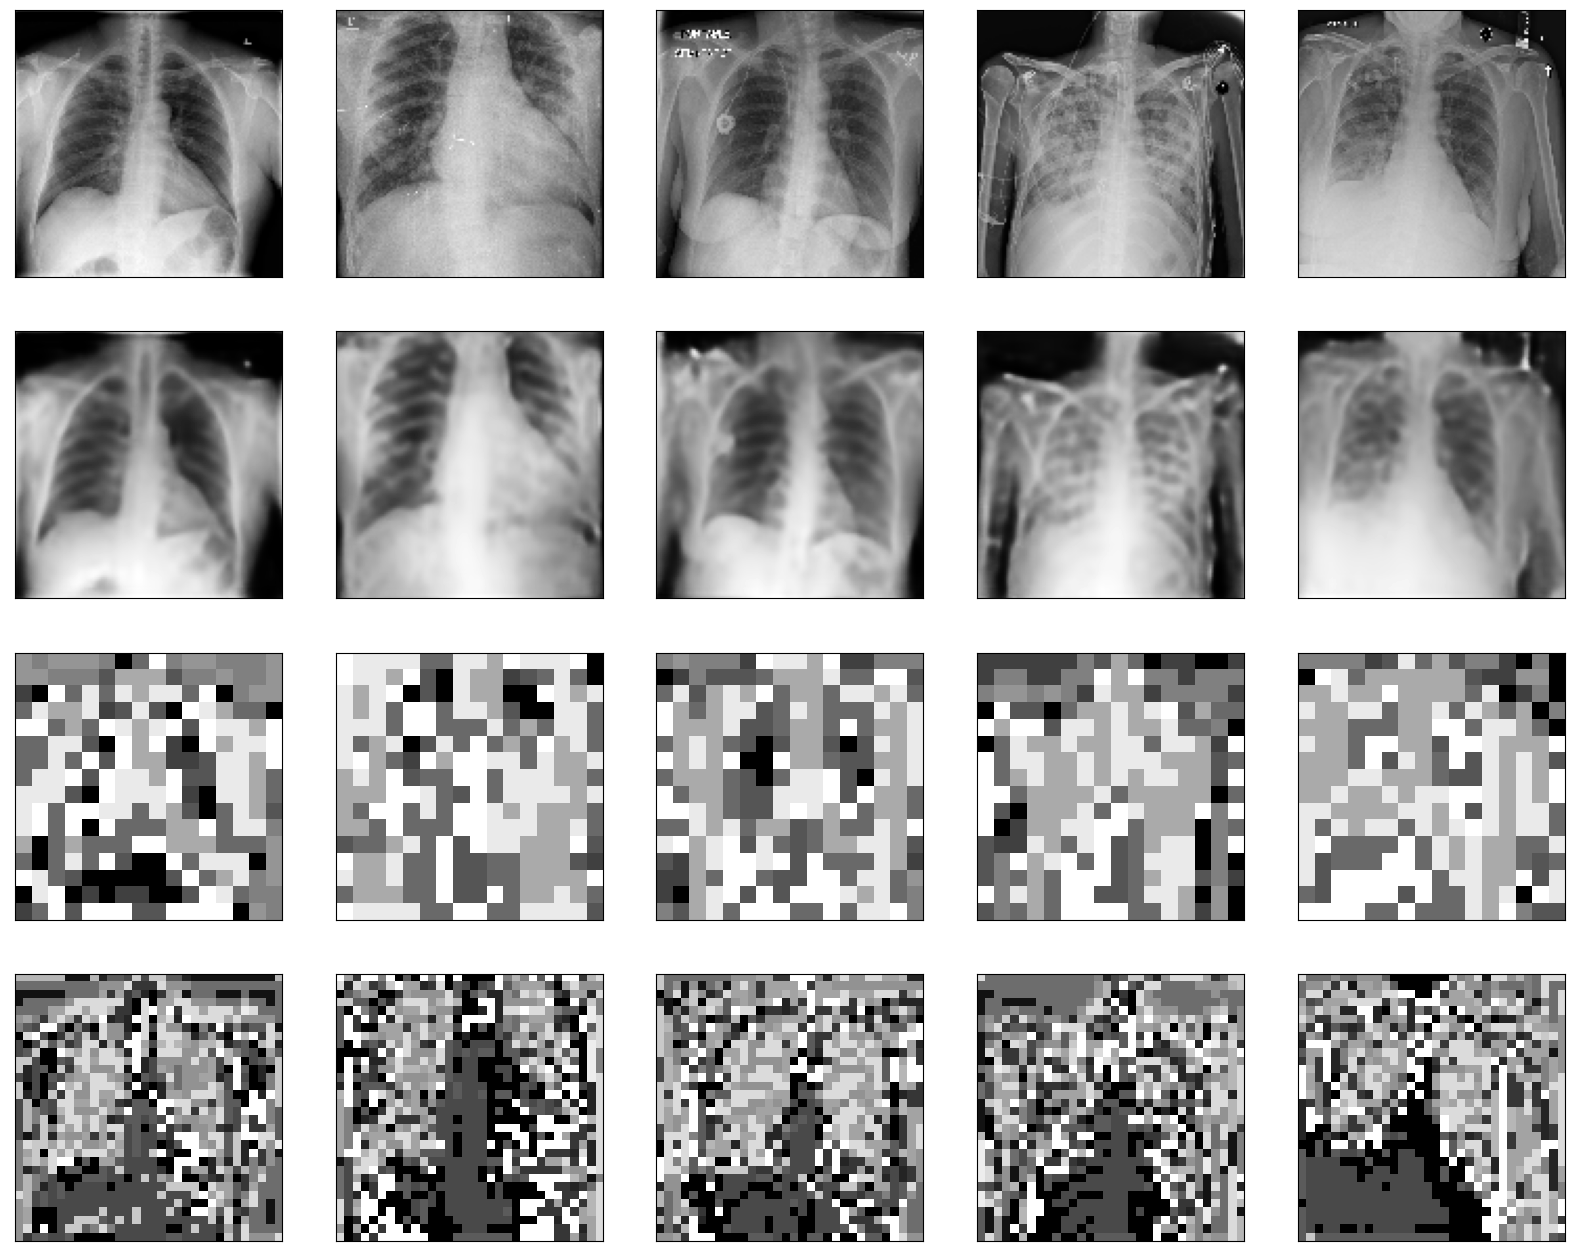

In [17]:
decoded_imgs, test_prior_t, test_prior_b = vae.predict(X_test)

n = 5
plt.figure(figsize=(20, 16))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(4, n, i)
    plt.imshow(np.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(4, n, i + n)
    plt.imshow(np.squeeze(decoded_imgs[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display prior_t
    ax = plt.subplot(4, n, i + n*2)
    plt.imshow(test_prior_t[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display prior_b
    ax = plt.subplot(4, n, i + n*3)
    plt.imshow(test_prior_b[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Sampling images

In [10]:
encoder_t = vae.get_layer("encoder_t")
quantizer_t = vae.get_layer("vector_quantizer_t")
decoder_t = vae.get_layer("decoder_t")
encoder_b = vae.get_layer("encoder_b")
quantizer_b = vae.get_layer("vector_quantizer_b")
decoder_b = vae.get_layer("decoder_b")

In [11]:
train_decoded_imgs, train_prior_t, train_prior_b = vae.predict(X_train)

313/313 [==============================] - 18s 37ms/step


In [13]:
class MaskedConv2D(keras.layers.Layer):
    def __init__(self,mask_type,ver_or_hor,filters,kernel_size,**kwargs):
        super().__init__(**kwargs)

        assert mask_type in ['A', 'B']
        assert ver_or_hor in ["V", "H"]
        self.mask_type = mask_type
        self.ver_or_hor = ver_or_hor
        
        if ver_or_hor == 'H':  # 1XN mask
            self.pad = (0, (kernel_size - 1) // 2)
            ksz = (1, kernel_size)

        else:  # NxN mask vertical
            ksz = kernel_size
            self.pad = (kernel_size - 1) // 2

        self.filters = filters
        self.kernel_size = kernel_size
        self.conv = layers.Conv2D(filters,
                                  ksz,
                                  padding="valid")

    def build(self, input_shape):
        kernel_h = self.kernel_size
        kernel_w = self.kernel_size
        self.conv.build(input_shape)

        mask = np.zeros(self.conv.kernel.get_shape(), dtype=np.float32)

        if self.mask_type == "A":
            if self.ver_or_hor == "V":
                mask[:kernel_h // 2, ...] = 1
            else:
                mask[:, :kernel_w // 2, ...] = 1
        else: #B
            if self.ver_or_hor == "V":
                mask[:kernel_h // 2 + 1, ...] = 1
            else:
                mask[:, :kernel_w // 2 +1,...] = 1
        
        self.mask = tf.constant(mask, name='mask')

    def call(self, inputs):
        self.conv.kernel.assign(self.conv.kernel * self.mask)
        x = self.conv(inputs)
        return layers.ZeroPadding2D(self.pad)(x)

    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'mask_type': self.mask_type,
            'ver_or_hor': self.ver_or_hor,
            'filters': self.filters,
            "kernel_size": self.kernel_size
        })
        return config

class GatedMaskedConv2d(layers.Layer):
    def __init__(self, mask_type, filters, kernel_size, **kwargs):
        super().__init__(**kwargs)

        self.mask_type = mask_type
        self.filters = filters
        self.kernel_size = kernel_size
        self.vertical_conv = MaskedConv2D(mask_type=mask_type, ver_or_hor="V",
                                        filters=2 * filters,
                                        kernel_size=kernel_size)

        self.horizontal_conv = MaskedConv2D(mask_type=mask_type, ver_or_hor="H",
                                            filters=2 * filters,
                                            kernel_size=kernel_size)

        self.v_to_h_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v, h = input_tensor

        vertical_preactivation = self.vertical_conv(v)
        horizontal_preactivation = self.horizontal_conv(h)

        v_to_h = self.v_to_h_conv(vertical_preactivation)
    
        v_out = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        
        h_activated = self._gate(horizontal_preactivation)
        h_activated = self.horizontal_output(h_activated)

        if self.mask_type == 'A':
            h_out = h_activated
        elif self.mask_type == 'B':
            h_out = h + h_activated

        return v_out, h_out

    def get_config(self): #Need this part to be able to save in .h5
        config = super().get_config() #.copy()
        config.update({
            'mask_type': self.mask_type,
            'filters': self.filters,
            "kernel_size": self.kernel_size
        })
        return config

## PixelCNN-top

In [28]:
input_shape = train_prior_t.shape[1:] + (1,)

In [29]:
pixelcnn_inputs = keras.Input(shape=input_shape[:-1], dtype=tf.uint8) 
ohe = tf.one_hot(pixelcnn_inputs, num_embeddings)
v, h = GatedMaskedConv2d(mask_type="A", filters=32, kernel_size=7)([ohe, ohe])

label_input = layers.Input(shape=())
cond = layers.Embedding(2, np.prod(input_shape), input_length=1)(label_input) #2 classes
cond = layers.Reshape(input_shape)(cond)
cond = tf.repeat(cond, 32, axis=-1)

v = keras.layers.Concatenate()([v, cond])
h = keras.layers.Concatenate()([h, cond])

for _ in range(5):
    v, h = GatedMaskedConv2d(mask_type="B", filters=64, kernel_size=3)([v, h])

out = keras.layers.Conv2D(filters=num_embeddings, kernel_size=1, padding="same")(h)

pixel_cnn_t = keras.Model([pixelcnn_inputs, label_input], out, name="pixel_cnn_t")
pixel_cnn_t.summary()

Model: "pixel_cnn_t"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 16, 16)]     0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256)          512         ['input_24[0][0]']               
                                                                                                  
 tf.one_hot (TFOpLambda)        (None, 16, 16, 16)   0           ['input_23[0][0]']               
                                                                                        

In [30]:
pixel_cnn_t.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [31]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [32]:
history = pixel_cnn_t.fit(
    x=[train_prior_t, y_train],
    y=train_prior_t,
    batch_size=32,
    epochs=100,
    validation_data=([test_prior_t, y_test], test_prior_t),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
313/313 [==============================] - 8s 19ms/step - loss: 1.5136 - accuracy: 0.4108 - val_loss: 1.3720 - val_accuracy: 0.4500 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 5s 17ms/step - loss: 1.3501 - accuracy: 0.4580 - val_loss: 1.3306 - val_accuracy: 0.4666 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 5s 17ms/step - loss: 1.3173 - accuracy: 0.4715 - val_loss: 1.3092 - val_accuracy: 0.4742 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2949 - accuracy: 0.4798 - val_loss: 1.2930 - val_accuracy: 0.4794 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2809 - accuracy: 0.4843 - val_loss: 1.2759 - val_accuracy: 0.4873 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 5s 17ms/step - loss: 1.2698 - accuracy: 0.4879 - val_loss: 1.2678 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 7/100
313/313 [==============================] - 5s 

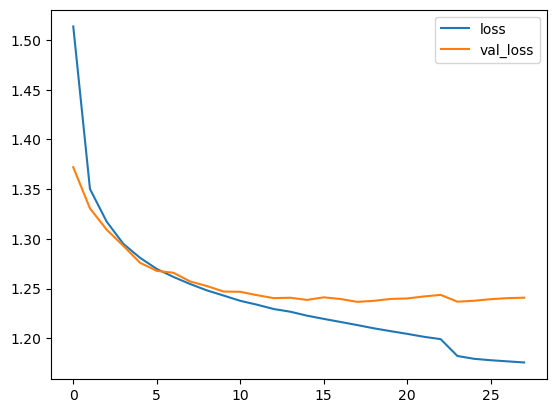

In [33]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

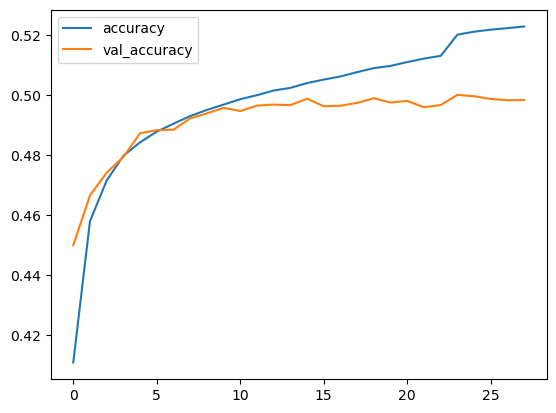

In [34]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [35]:
pixel_cnn_t.save(pixelcnnt_model_path)

In [14]:
#optional
pixel_cnn_t = keras.models.load_model(pixelcnnt_model_path, 
                                    custom_objects={"MaskedConv2D": MaskedConv2D, 
                                                    "GatedMaskedConv2d": GatedMaskedConv2d})

## PixelCNN-bottom

In [18]:
input_shape = test_prior_b.shape[1:]
cond_shape = test_prior_t.shape[1:]
input_shape, cond_shape

((32, 32), (16, 16))

In [26]:
pixelcnn_inputs = keras.Input(shape=input_shape, dtype=tf.uint8) #, dtype=tf.uint8
ohe = tf.one_hot(pixelcnn_inputs, num_embeddings)
v, h = GatedMaskedConv2d(mask_type="A", filters=32, kernel_size=7)([ohe, ohe])

label_input = layers.Input(shape=())
label_cond = layers.Embedding(2, np.prod(input_shape), input_length=1)(label_input) #2 classes
label_cond = layers.Reshape(input_shape + (1,))(label_cond)
label_cond = tf.repeat(label_cond, 16, axis=-1)


pixelcnn_inputs_t = keras.Input(shape=cond_shape, dtype=tf.uint8)
pixelcnn_inputs_t_aug = tf.expand_dims(pixelcnn_inputs_t, -1)
pixelcnn_inputs_t_aug = layers.UpSampling2D()(pixelcnn_inputs_t_aug)
pixelcnn_inputs_t_aug = tf.squeeze(pixelcnn_inputs_t_aug, axis=-1)
ohe_t = tf.one_hot(pixelcnn_inputs_t_aug, num_embeddings)
ohe_t = layers.Conv2D(16, 3, padding="same", activation="relu")(ohe_t)

v = keras.layers.Concatenate()([v, ohe_t, label_cond])
h = keras.layers.Concatenate()([h, ohe_t, label_cond])

for _ in range(5):
    v, h = GatedMaskedConv2d(mask_type="B", filters=64, kernel_size=3)([v, h])

out = keras.layers.Conv2D(filters=num_embeddings, kernel_size=1, padding="same")(h)

pixel_cnn_b = keras.Model([pixelcnn_inputs, pixelcnn_inputs_t, label_input], out, name="pixel_cnn_b")
pixel_cnn_b.summary()

Model: "pixel_cnn_b"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 16, 16)]     0           []                               
                                                                                                  
 tf.expand_dims_5 (TFOpLambda)  (None, 16, 16, 1)    0           ['input_22[0][0]']               
                                                                                                  
 up_sampling2d_5 (UpSampling2D)  (None, 32, 32, 1)   0           ['tf.expand_dims_5[0][0]']       
                                                                                                  
 input_21 (InputLayer)          [(None,)]            0           []                               
                                                                                        

In [27]:
pixel_cnn_b.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #from_logits=True porque no hemos metido softmax en la ultima capa
    metrics=["accuracy"],
)

In [28]:
early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0.0005, patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [29]:
history = pixel_cnn_b.fit(
    x=[train_prior_b, train_prior_t, y_train],
    y=train_prior_b,
    batch_size=32,
    epochs=100,
    validation_data=([test_prior_b, test_prior_t, y_test], test_prior_b),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/100
313/313 [==============================] - 16s 42ms/step - loss: 1.6535 - accuracy: 0.4143 - val_loss: 1.4247 - val_accuracy: 0.4776 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 13s 41ms/step - loss: 1.4721 - accuracy: 0.4631 - val_loss: 1.3525 - val_accuracy: 0.4957 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 13s 41ms/step - loss: 1.4206 - accuracy: 0.4770 - val_loss: 1.3106 - val_accuracy: 0.5083 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 13s 42ms/step - loss: 1.3879 - accuracy: 0.4863 - val_loss: 1.2816 - val_accuracy: 0.5169 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 1.3646 - accuracy: 0.4932 - val_loss: 1.2692 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 1.3481 - accuracy: 0.4985 - val_loss: 1.2511 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 7/100
313/313 [==============================]

313/313 [==============================] - 13s 42ms/step - loss: 1.2341 - accuracy: 0.5351 - val_loss: 1.1799 - val_accuracy: 0.5498 - lr: 0.0010
Epoch 53/100
313/313 [==============================] - 13s 42ms/step - loss: 1.2335 - accuracy: 0.5354 - val_loss: 1.1803 - val_accuracy: 0.5501 - lr: 0.0010
Epoch 54/100
313/313 [==============================] - 13s 42ms/step - loss: 1.2329 - accuracy: 0.5355 - val_loss: 1.1806 - val_accuracy: 0.5499 - lr: 0.0010
Epoch 55/100
313/313 [==============================] - 13s 42ms/step - loss: 1.2212 - accuracy: 0.5394 - val_loss: 1.1738 - val_accuracy: 0.5520 - lr: 2.0000e-04
Epoch 56/100
313/313 [==============================] - 13s 42ms/step - loss: 1.2199 - accuracy: 0.5399 - val_loss: 1.1750 - val_accuracy: 0.5518 - lr: 2.0000e-04
Epoch 57/100
313/313 [==============================] - 13s 42ms/step - loss: 1.2196 - accuracy: 0.5399 - val_loss: 1.1745 - val_accuracy: 0.5521 - lr: 2.0000e-04
Epoch 58/100
313/313 [=========================

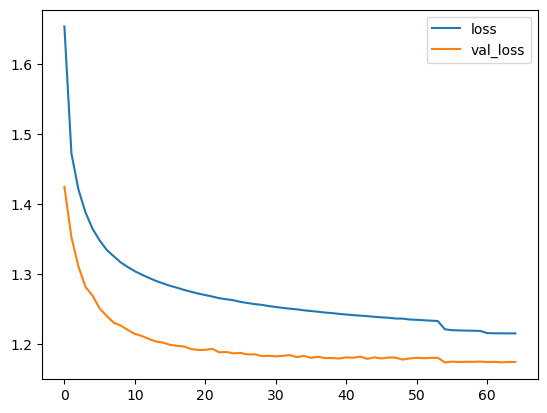

In [30]:
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

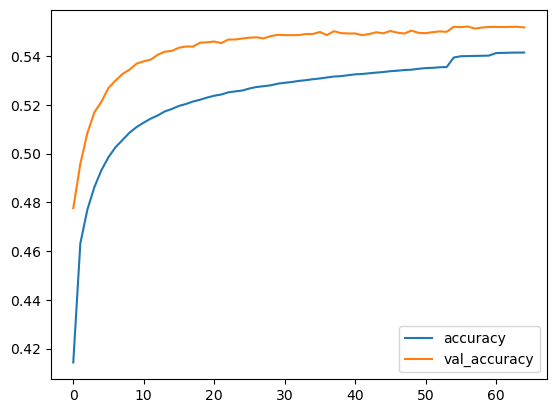

In [31]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [32]:
pixel_cnn_b.save(pixelcnnb_model_path)

In [87]:
# Optional
pixel_cnn_b = keras.models.load_model(pixelcnnb_model_path, 
                                    custom_objects={"MaskedConv2D": MaskedConv2D, 
                                                    "GatedMaskedConv2d": GatedMaskedConv2d})

## Sampling

In [114]:
labels = np.array([0,0,1,1])
batch = len(labels)
cond_inp_str = np.where(labels==0, "negative", "positive")

In [115]:
def get_t_sampler(input_shape=(16,16)):
    # Create a mini sampler model.
    inputs = layers.Input(shape=input_shape)
    inputs_cond = layers.Input(shape=())
    outputs = pixel_cnn_t([inputs, inputs_cond], training=False)
    categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
    outputs = categorical_layer(outputs)
    return keras.Model([inputs, inputs_cond], outputs)
t_sampler = get_t_sampler()

In [116]:
t_sampler.output.shape

TensorShape([None, 16, 16])

In [117]:
def get_t_sample(sampler, labels):
    # Create an empty array of priors.
    batch = len(labels)
    input_shape=t_sampler.output.shape[1:]
    priors = np.zeros(shape=(batch,) + (input_shape))
    priors = np.squeeze(priors)
    batch, rows, cols = priors.shape
    cond_inp = labels
    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in tqdm(range(rows)):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict([np.expand_dims(priors,-1), cond_inp], verbose=0)
            # Use the probabilities to pick pixel values and append the values to the priors.
            probs = np.squeeze(probs)
            priors[:, row, col] = probs[:, row, col]
    return priors
sampled_t = get_t_sample(t_sampler, labels)

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [00:13<00:00,  1.18it/s]


In [118]:
def get_b_sampler(input_shape=(32,32), cond_input_shape=(16,16)):
    # Create a mini sampler model.
    inputs = layers.Input(shape=input_shape)
    inputs_cond = layers.Input(shape=cond_input_shape)
    inputs_label = layers.Input(shape=())
    outputs = pixel_cnn_b([inputs, inputs_cond, inputs_label], training=False)
    categorical_layer = tfp.layers.DistributionLambda(tfp.distributions.Categorical)
    outputs = categorical_layer(outputs)
    return keras.Model([inputs, inputs_cond, inputs_label], outputs)
sampler_b = get_b_sampler()

In [119]:
def get_b_sample(sampler, cond_inp, label_inp, batch=5):
    # Create an empty array of priors.
    input_shape=sampler.output.shape[1:]
    priors = np.zeros(shape=(batch,) + (input_shape))
    priors = np.squeeze(priors)
    batch, rows, cols = priors.shape
    
    # Iterate over the priors because generation has to be done sequentially pixel by pixel.
    for row in tqdm(range(rows)):
        for col in range(cols):
            # Feed the whole array and retrieving the pixel value probabilities for the next
            # pixel.
            probs = sampler.predict([np.expand_dims(priors,-1), cond_inp, label_inp], verbose=0)
            # Use the probabilities to pick pixel values and append the values to the priors.
            probs = np.squeeze(probs)
            priors[:, row, col] = probs[:, row, col]
    return priors

sampled_b = get_b_sample(sampler_b, sampled_t, labels, batch=batch)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [01:17<00:00,  2.42s/it]


In [120]:
quantized_t = quantizer_t.quantize_from_priors(sampled_t)
quantized_b = quantizer_b.quantize_from_priors(sampled_b)

In [121]:
quantized_t.shape, quantized_b.shape

((4, 16, 16, 8), (4, 32, 32, 16))

In [122]:
quantized_t = layers.UpSampling2D(size=(2, 2))(quantized_t)
quantized_t.shape

TensorShape([4, 32, 32, 8])

In [123]:
quantized = layers.Concatenate()([quantized_b, quantized_t])

In [124]:
generated_samples = decoder_b.predict(quantized)

1/1 [==============================] - 0s 16ms/step


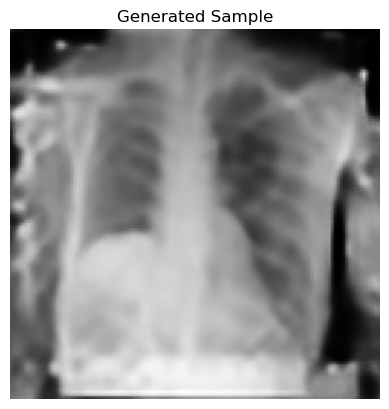

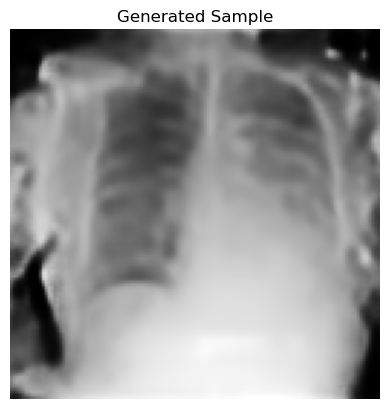

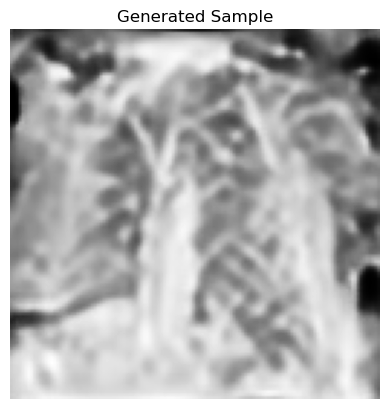

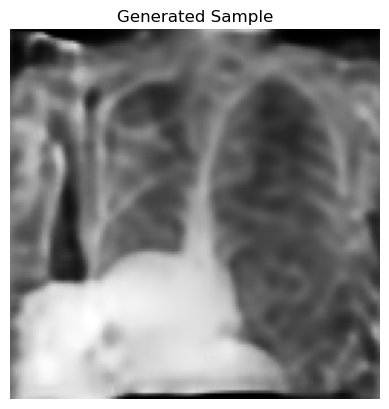

In [125]:
for i in range(batch):
    plt.imshow(generated_samples[i].squeeze(), cmap="gray")
    plt.title("Generated Sample")
    plt.axis("off")
    plt.show()

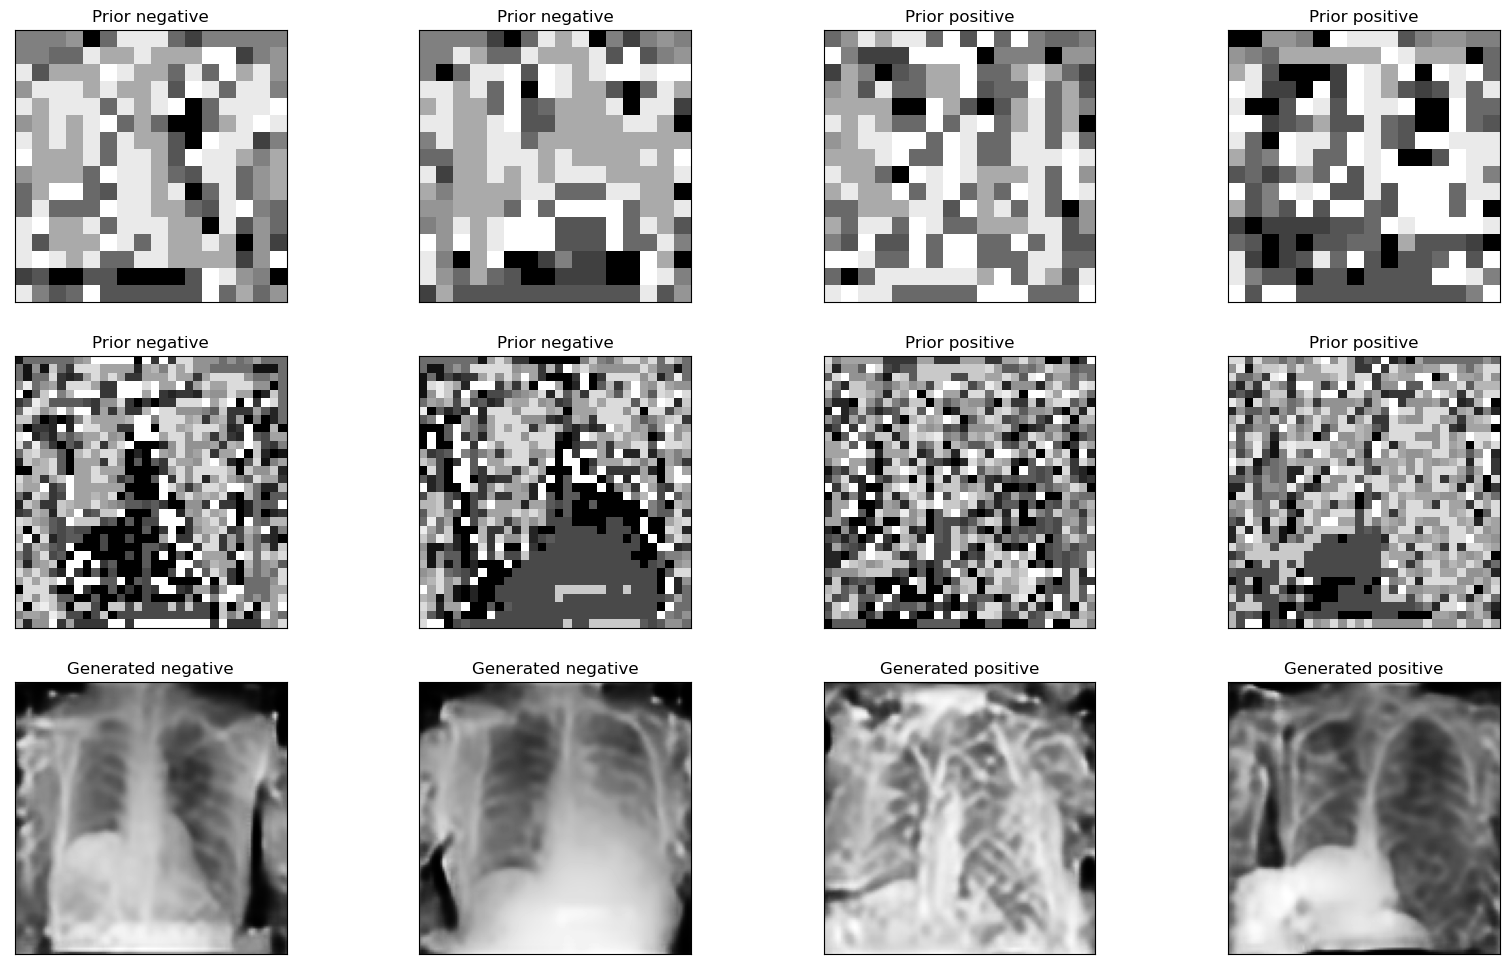

In [126]:
plt.figure(figsize=(20, 12))
for i in range(1, batch + 1):
    # Display priors
    ax = plt.subplot(3, batch, i)
    plt.imshow(sampled_t[i-1], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Prior {cond_inp_str[i-1]}")
    
    # Display priors
    ax = plt.subplot(3, batch, i + batch)
    plt.imshow(sampled_b[i-1], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Prior {cond_inp_str[i-1]}")

    # Display generated_img
    ax = plt.subplot(3, batch, i + 2*batch)
    plt.imshow(generated_samples[i-1], cmap="gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"Generated {cond_inp_str[i-1]}")
plt.show()